In [56]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx
from networkx.algorithms import community
import community as community_louvain
import collections

In [57]:
df = pd.read_excel('Data.xlsx')

In [58]:
#Nation renaming
df.rename(columns={'Points      ': 'Points'},inplace=True)
df['From country'] = df['From country'].str.replace('The Netherands','Netherlands')
df['To country'] = df['To country'].str.replace('The Netherands','Netherlands')
df['From country'] = df['From country'].str.replace('The Netherlands','Netherlands')
df['To country'] = df['To country'].str.replace('The Netherlands','Netherlands')
df['From country'] = df['From country'].str.replace('F.Y.R. Macedonia','Macedonia')
df['To country'] = df['To country'].str.replace('F.Y.R. Macedonia','Macedonia')
df['From country'] = df['From country'].str.replace('North Macedonia','Macedonia')
df['To country'] = df['To country'].str.replace('North Macedonia','Macedonia')
df['From country'] = df['From country'].str.replace('Bosnia & Herzegovina','Boznia&Herz')
df['To country'] = df['To country'].str.replace('Bosnia & Herzegovina','Boznia&Herz')  
df['From country'] = df['From country'].str.replace('Czech Republic','Czechia')
df['To country'] = df['To country'].str.replace('Czech Republic','Czechia')
df['From country'] = df['From country'].str.replace('United Kingdom','UK')
df['To country'] = df['To country'].str.replace('United Kingdom','UK')

#Drop Bosnia & Herzegovina for not earning points in a final
temp = df[df['From country']=='Boznia&Herz'].index 
df = df.drop(temp)
temp = df[df['To country']=='Boznia&Herz'].index 
df = df.drop(temp)

/var/folders/hx/m3n3wwr91yg_snnv68ynqsp80000gn/T/ipykernel_95318/4054239133.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['From country'] = df['From country'].str.replace('F.Y.R. Macedonia','Macedonia')
/var/folders/hx/m3n3wwr91yg_snnv68ynqsp80000gn/T/ipykernel_95318/4054239133.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['To country'] = df['To country'].str.replace('F.Y.R. Macedonia','Macedonia')


In [59]:
#Select only, finals, televotes
temp = df[df['(semi-) final']!='f'].index
df = df.drop(temp)
temp = df[df['Jury or Televoting']=='J'].index
df = df.drop(temp)

#Scale points to remove weighting to 1st and 2nd
df.replace(10, 9, inplace=True)
df.replace(12, 10, inplace=True)

In [60]:
#Calculate the points scored by each nation each year
pointsScored = np.zeros((len(df['To country'].unique()), len(df['Year'].unique())))
for i, country in enumerate(df['To country'].unique()):
    for k, year in enumerate(df['Year'].unique()):
        pointsScored[i,k] = df[df['Year']==year][df['To country']==country].Points.sum()

/var/folders/hx/m3n3wwr91yg_snnv68ynqsp80000gn/T/ipykernel_95318/3929646966.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pointsScored[i,k] = df[df['Year']==year][df['To country']==country].Points.sum()


In [61]:
#Calculate point proportions and average them
for i, country in enumerate(df['To country'].unique()):
    for k, year in enumerate(df['Year'].unique()):
        indx = df[df['Year']==year][df['To country']==country]['Points'].index
        for ind in indx:
            if pointsScored[i, k] == 0:
                df.loc[ind, 'Points'] = np.NaN
            else:
                df.loc[ind, 'Points'] = (df.loc[ind, 'Points']) / (pointsScored[i, k]) 

/var/folders/hx/m3n3wwr91yg_snnv68ynqsp80000gn/T/ipykernel_95318/150788869.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indx = df[df['Year']==year][df['To country']==country]['Points'].index


In [62]:
dfAverages = df.groupby(['From country','To country']).Points.mean()
dfAverages

From country  To country 
Albania       Albania        0.000000
              Armenia        0.003906
              Australia      0.014200
              Austria        0.009524
              Azerbaijan     0.007732
                               ...   
Ukraine       Spain          0.000000
              Sweden         0.022691
              Switzerland    0.025210
              UK             0.000000
              Ukraine        0.000000
Name: Points, Length: 1839, dtype: float64

In [63]:
dfAverages = dfAverages.unstack().fillna(0)

In [64]:
#Find louvian groups
np_matrix = dfAverages.values
names = dfAverages.columns
print(names)
G = nx.from_numpy_array(np_matrix)
G = nx.relabel_nodes(G, dict(enumerate(names)))
partition = community_louvain.best_partition(G)

Index(['Albania', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Belarus',
       'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
       'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Latvia',
       'Lithuania', 'Macedonia', 'Malta', 'Moldova', 'Montenegro',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia',
       'San Marino', 'Serbia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
       'UK', 'Ukraine'],
      dtype='object', name='To country')


In [65]:
#Asign groups on pandaframe
partition = collections.OrderedDict(sorted(partition.items())) 
dfAverages['group'] = partition.values()
dfAverages = dfAverages.sort_values(by ='group')

In [66]:
dfAverages

To country,Albania,Armenia,Australia,Austria,Azerbaijan,Belarus,Belgium,Bulgaria,Croatia,Cyprus,...,Russia,San Marino,Serbia,Slovenia,Spain,Sweden,Switzerland,UK,Ukraine,group
From country,,,,,,,,,,,,,,,,,,,,,
Albania,0.000000,0.003906,0.014200,0.009524,0.007732,0.000000,0.010406,0.056278,0.035714,0.007438,...,0.024219,0.155914,0.000000,0.000000,0.049145,0.016446,0.009662,0.020833,0.005137,0
Italy,0.182683,0.007603,0.009375,0.008036,0.002062,0.000000,0.004511,0.022031,0.030612,0.027662,...,0.022702,0.138889,0.039779,0.000000,0.012821,0.001866,0.032456,0.000000,0.115390,0
Montenegro,0.148542,0.001412,0.000000,0.005357,0.087710,0.000000,0.005533,0.036872,0.181455,0.011275,...,0.044343,0.064516,0.162232,0.280513,0.012821,0.025221,0.021008,0.000000,0.029355,0
Croatia,0.050366,0.000000,0.006906,0.026316,0.000000,0.000000,0.010373,0.015612,0.000000,0.008264,...,0.012270,0.032258,0.161310,0.231121,0.000000,0.017290,0.028986,0.000000,0.010274,0
Serbia,0.019608,0.005208,0.006630,0.000000,0.000000,0.000000,0.044846,0.035444,0.112467,0.019203,...,0.033554,0.016129,0.000000,0.217956,0.007843,0.008352,0.028986,0.000000,0.007991,0
Macedonia,0.182683,0.036947,0.003315,0.005357,0.002062,0.000000,0.035646,0.064482,0.154614,0.006612,...,0.015843,0.064516,0.150319,0.193871,0.000000,0.013395,0.039074,0.000000,0.014066,0
Slovenia,0.033861,0.000000,0.006440,0.029229,0.021053,0.000000,0.015280,0.011283,0.224933,0.004959,...,0.011549,0.000000,0.157232,0.000000,0.000000,0.016736,0.039074,0.000000,0.005993,0
Belgium,0.031373,0.048923,0.010670,0.024436,0.000000,0.000000,0.000000,0.018156,0.000000,0.005785,...,0.012248,0.000000,0.000000,0.000000,0.034565,0.017708,0.012077,0.000000,0.001712,1
Latvia,0.000000,0.007062,0.017592,0.014129,0.017622,0.103030,0.022557,0.009345,0.000000,0.000826,...,0.049039,0.000000,0.000000,0.045809,0.000000,0.022133,0.010819,0.000000,0.032751,1


In [67]:
# only keep index and group
see = dfAverages[['group']]
see.to_clipboard()

In [68]:
#Calculate stats of clusters
clusters = dfAverages['group'].unique()
for c in clusters:
    names = dfAverages[dfAverages['group']==c].index
    temp = dfAverages[names]
    m = np.zeros((len(names),len(names)))
    for i, n in enumerate(names):
        for i2, n2 in enumerate(names):
            t = temp[n]
            if n != n2:
                m[i,i2] = t[n2]
            else:
                m[i,i2] = np.NaN

    print(str(c) + ' mean: ' + str(np.nanmean(m)))
    print(str(c) + ' std: ' + str(np.nanstd(m)))
    print(str(c) + ' Sym: ' + str(np.nanmean(np.abs(m-np.transpose(m)))/2))

print(dfAverages)

0 mean: 0.11493318982038314
0 std: 0.08808908031064813
0 Sym: 0.026039753949541996
1 mean: 0.04310717668405525
1 std: 0.06032302037911682
1 Sym: 0.019603764661880217
2 mean: 0.05770598839886189
2 std: 0.06896026145636588
2 Sym: 0.027757996138476074
3 mean: 0.11991627647381749
3 std: 0.16529393624477887
3 Sym: 0.0995095349658448
4 mean: 0.06877085795948043
4 std: 0.10439100179739501
4 Sym: 0.023216345187871794
To country     Albania   Armenia  Australia   Austria  Azerbaijan   Belarus  \
From country                                                                  
Albania       0.000000  0.003906   0.014200  0.009524    0.007732  0.000000   
Italy         0.182683  0.007603   0.009375  0.008036    0.002062  0.000000   
Montenegro    0.148542  0.001412   0.000000  0.005357    0.087710  0.000000   
Croatia       0.050366  0.000000   0.006906  0.026316    0.000000  0.000000   
Serbia        0.019608  0.005208   0.006630  0.000000    0.000000  0.000000   
Macedonia     0.182683  0.036947  

In [69]:
dfAverages.drop(columns=['group'], inplace=True)
dfAverages = dfAverages[dfAverages.axes[0]]

In [70]:
#Calculate stats of all nations
np_matrix = dfAverages.values
m = np_matrix.copy()
for i, n in enumerate(names):
    for i2, n2 in enumerate(names):
        t = temp[n]
        if n == n2:
            m[i,i2] = np.NaN
print('All mean: ' + str(np.nanmean(m)))
print('All std: ' + str(np.nanstd(m)))
print('All Sym: ' + str(np.nanmean(np.abs(m-np.transpose(m)))/2))

All mean: 0.024889350846031298
All std: 0.04781922866007721
All Sym: 0.012528944475611162


In [71]:
#Calculate Asymmetry of each nation
df = pd.DataFrame(columns=list(['Name', 'Asymmetry']))
for i in range(0, np_matrix.shape[0]):
    total = 0
    for k in range(0, np_matrix.shape[0]):
        total += np.abs(np_matrix[i,k] - np_matrix[k,i])
    df = df.append({'Name' : dfAverages.axes[0][i], 'Asymmetry' : total/np_matrix.shape[0]}, ignore_index=True)
df = df.sort_values(by=['Asymmetry'])
print(df)

           Name  Asymmetry
3       Croatia   0.013152
38       Cyprus   0.015010
18       Norway   0.015695
6      Slovenia   0.016133
9        Sweden   0.016265
14  Netherlands   0.016370
17      Denmark   0.016397
8        Latvia   0.017866
5     Macedonia   0.017917
37       Greece   0.019117
22      Estonia   0.019557
23      Moldova   0.020570
26       Israel   0.020855
4        Serbia   0.021578
39      Romania   0.022990
40     Bulgaria   0.023241
32      Ukraine   0.023253
42      Hungary   0.023296
20      Austria   0.023672
7       Belgium   0.024097
12      Iceland   0.024568
27      Georgia   0.024686
15      Finland   0.025270
19       Poland   0.025598
24        Malta   0.026192
31      Armenia   0.026784
29      Belarus   0.027058
16    Lithuania   0.027139
25       Russia   0.027497
33      Germany   0.027994
28      Czechia   0.028505
35        Spain   0.028857
1         Italy   0.029167
13    Australia   0.029273
21       France   0.029845
2    Montenegro   0.030000
3

/var/folders/hx/m3n3wwr91yg_snnv68ynqsp80000gn/T/ipykernel_95318/3311697379.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Name' : dfAverages.axes[0][i], 'Asymmetry' : total/np_matrix.shape[0]}, ignore_index=True)
/var/folders/hx/m3n3wwr91yg_snnv68ynqsp80000gn/T/ipykernel_95318/3311697379.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Name' : dfAverages.axes[0][i], 'Asymmetry' : total/np_matrix.shape[0]}, ignore_index=True)
/var/folders/hx/m3n3wwr91yg_snnv68ynqsp80000gn/T/ipykernel_95318/3311697379.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Name' : dfAverages.axes[0][i], 'Asymmetry' : total/np_matrix.shape[0]}, ignore_index=True)
/var/folders/hx/m3n3wwr91

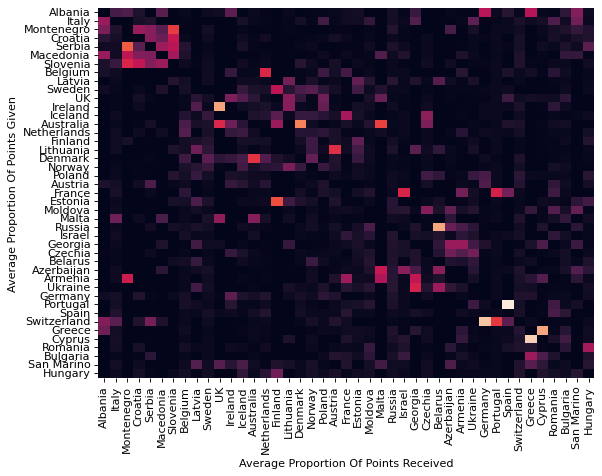

In [72]:
#Create heatmap
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
x_axis_labels = dfAverages.axes[1] # labels for x-axis
y_axis_labels = dfAverages.axes[0] # labels for y-axis
sns.heatmap(np_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels,cbar=False)
plt.xlabel("Average Proportion Of Points Received")
plt.ylabel("Average Proportion Of Points Given")
plt.show()